In [1]:
import importlib
import codebase
codebase = importlib.reload(codebase)
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

In [2]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D

In [3]:
py_data = loadmat('data/py_odes.mat')
oct_data = loadmat('data/oct_odes.mat')
mult_data = loadmat('data/py_odes_mult_traj.mat')
timestep = py_data['t'][0, 1]
oct_data.keys()

dict_keys(['linear_oscillator', 'cubic_oscillator', 'oscillator_3d', 'lorenz', 'mean_field', 'van_der_pol', 't'])

In [5]:
function = 'van_der_pol'

data = mult_data[function]

derivatives, dm, m = make_targets(data)
derivatives = derivatives/timestep
real_derivatives = np.array([functions[function](0, x) for x in m], dtype=np.float32)
nb_variables = m.shape[1]
variables = ['1', 'x', 'y', 'z']
X, nb_funcs = make_polynomials(m, max_degree=5)

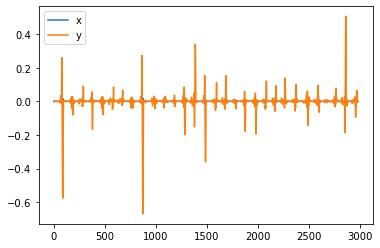

In [6]:
for dim in range(nb_variables):
    plt.plot(derivatives[:, dim] - real_derivatives[:, dim], label=variables[1:][dim])
plt.legend()
plt.show()

In [10]:
cutoff = 1e-1
max_degree = 3
function = 'van_der_pol'
loss = tf.keras.metrics.MeanSquaredError()

data = py_data[function]
derivatives, dm, m = make_targets(data)
derivatives = derivatives/timestep
nb_variables = m.shape[1]
X, nb_funcs = make_polynomials(m, max_degree=max_degree)
weights, iterations = sparse_regression(X, derivatives, cutoff=cutoff)

    
metrics = {'iterations':[iterations],
           'examples':[len(dm)],
           'loss':[loss(derivatives, tf.matmul(X, weights))]} # tf.matmul(X, weights)
params = [[reduce(''.join(name), variables)] + list(val)
          for name, val in zip(combinations_with_replacement(variables[:1 + nb_variables], 5), weights.numpy())]

print(tabulate(metrics, headers=metrics.keys(), tablefmt="pipe"))
print()
print(tabulate(params, headers=['function', '$\dot{x}$', '$\dot{y}$', '$\dot{z}$'], tablefmt="pipe"))

|   iterations |   examples |       loss |
|-------------:|-----------:|-----------:|
|            2 |        298 | 0.00338224 |

| function   |   $\dot{x}$ |   $\dot{y}$ |
|:-----------|------------:|------------:|
| $1$        |    0        |    0        |
| $ x$       |    0        |   -0.99125  |
| $ y$       |    0.999718 |    0.98747  |
| $ x^2$     |    0        |    0        |
| $ x y$     |    0        |    0        |
| $ y^2$     |    0        |    0        |
| $ x^3$     |    0        |    0        |
| $ x^2 y$   |    0        |   -0.983185 |
| $ x y^2$   |    0        |    0        |
| $ y^3$     |    0        |    0        |
